In [1]:
import os
from glob import glob
import librosa
import librosa.display as lds
import IPython.display as ipd
import matplotlib.pyplot as plt

#https://medium.com/analytics-vidhya/adding-noise-to-audio-clips-5d8cee24ccb8

In [30]:
PATH = '../ru_audio/'
PATH_N = '../noise/noise_files/'
clean_ru  = [y for x in os.walk(PATH) for y in glob(os.path.join(x[0], '*.wav'))]
noise_files= [y for x in os.walk(PATH_N) for y in glob(os.path.join(x[0], '*.wav'))]

In [88]:
mixed_path = './dataset_mixed'
mixed_files= [y for x in os.walk(mixed_path) for y in glob(os.path.join(x[0], '*.wav'))]

In [91]:
signal, sr = librosa.load(mixed_files[2])
ipd.Audio(signal, rate=sr)

In [53]:
import numpy as np
import math as m

rms = lambda x: m.sqrt(np.mean(x**2))

def snr(signal, noise):
    r_s = rms(signal)
    r_n = rms(noise)
    return 20*np.log10(r_s/r_n)

def get_noise_scale(signal, snr):
    r_s = rms(signal)
    snr_ten = m.pow(10, snr/10)
    return r_s/m.sqrt(snr_ten)

def get_random_noise_snr(signal, snr):
    scale = get_noise_scale(signal, snr)
    size = signal.shape[0]
    return np.random.normal(loc=0, scale=scale, size=size)

def get_snr_scaled_noise(signal, noise, snr):
    scale = get_noise_scale(signal, snr)
    r_n = rms(noise)
    return noise*(scale/r_n)

def mix_sounds(sound_one, sound_two):
    min_len = min(len(sound_one), len(sound_two))
    return sound_one[:min_len] + sound_two[:min_len]

In [3]:
def plot_spectr(signal, axes=None):
    mag, _ = librosa.magphase(librosa.stft(signal, 
                         n_fft=320, 
                         hop_length=160, 
                         win_length=320))
    librosa.display.specshow(
                    librosa.amplitude_to_db(mag),
                    cmap="jet",
                    y_axis="linear",
                    ax=axes,
                    sr=1600,
                )

In [13]:
snr(signal, get_noise_scale(signal, 2))

2.0000000000000004

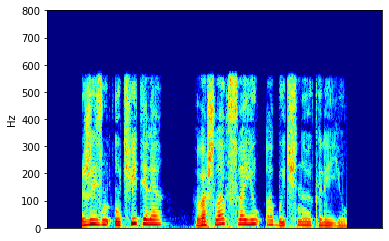

In [14]:
plot_spectr(signal)

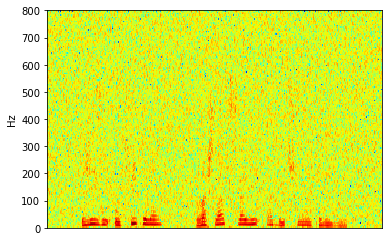

In [15]:
plot_spectr(signal + get_random_noise_snr(signal, 1))

In [16]:
sr = 22000
ipd.Audio(signal+get_random_noise_snr(signal, 20), rate=sr)

In [49]:
signal_one, sr = librosa.load(clean_ru[223])
signal_two, sr = librosa.load(noise_files[1])

In [104]:
ipd.Audio(signal_two, rate=sr)

In [5]:
ipd.Audio(signal_one, rate=sr)

In [54]:
ipd.Audio(mix_sounds(signal_one, signal_two), rate=sr)

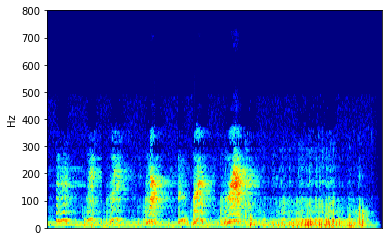

In [67]:
plot_spectr(signal_two)

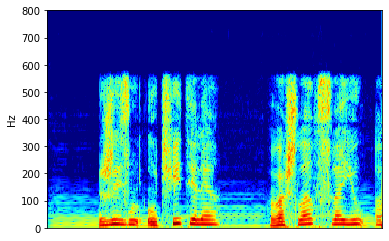

In [84]:
noise = get_snr_scaled_noise(signal_one, signal_two,20)
mixed = mix_sounds(signal_one, noise)
plot_spectr(mixed)

In [85]:
ipd.Audio(mixed, rate=sr)

### TORCH AUDIO VERSION

In [35]:
import torchaudio as ta

In [69]:
waveform, sr = ta.load(noise_files[1])

signal_one, sr1 = ta.load(clean_ru[223])
signal_two, sr2 = ta.load(noise_files[1])

TypeError: Expected a tensor, got <class 'int'>

In [62]:
resmaple  = ta.transforms.Resample(orig_freq=44100, new_freq =16000, resampling_method = 'sinc_interpolation')

In [65]:
ipd.Audio(mix_sounds(signal_one[0].numpy(), signal_two[0].numpy()), rate=sr1)

In [67]:
signal_two = resmaple(signal_two)

In [68]:
ipd.Audio(mix_sounds(signal_one[0].numpy(), signal_two[0].numpy()), rate=sr1)

In [ ]:
mag, _ = librosa.magphase(librosa.stft(signal, 
                     n_fft=320, 
                     hop_length=160, 
                     win_length=320))
librosa.display.specshow(
                librosa.amplitude_to_db(mag),
                cmap="jet",
                y_axis="linear",
                ax=axes,
                sr=1600,
            )

In [69]:
specgram = ta.transforms.Spectrogram(n_fft=320, win_length=320, hop_length=160)(waveform)
specgram = ta.transforms.AmplitudeToDB()(specgram)

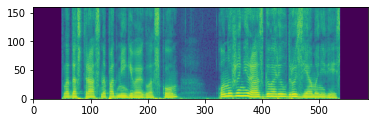

In [70]:
plt.imshow(specgram[0,:,:])
plt.gca().invert_yaxis()

In [26]:
def plot_spectr(signal, axes=None):
    mag, _ = librosa.magphase(librosa.stft(signal, 
                         n_fft=320, 
                         hop_length=160, 
                         win_length=320))
    librosa.display.specshow(
                    librosa.amplitude_to_db(mag),
                    cmap="jet",
                    y_axis="linear",
                    ax=axes,
                    sr=1600,
                )

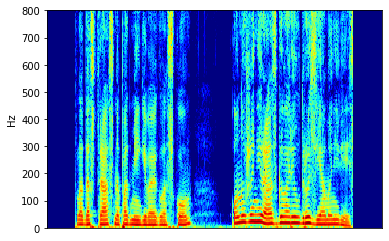

In [30]:
plot_spectr(waveform.numpy()[0], axes=None)

In [29]:
waveform

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

Mix aduio process

1. Read several random bakcground - noise files and one clean - noise file.
2. Align noise series to clean length
3. Apply random SNR noise in range  2 - 20
4. Apply noise + clean SNR in range 2 - 20

In [6]:
batch = read_random_batch(noise_files, batch_size=32, workers=5, new_length=len(signal_one))

In [24]:
batch.shape

torch.Size([32, 105506])

In [25]:
sr = 22000
ipd.Audio(batch[8].numpy(), rate=sr)

In [77]:
import numpy as np
import math as m

rms = lambda x: torch.pow(torch.pow(x, 2).mean(1),0.5)

def snr(signal, noise):
    r_s = rms(signal)
    r_n = rms(noise)
    return 20*torch.log10(r_s/r_n)

def get_noise_scale(signal, snr):
    r_s = rms(signal)
    snr_ten = torch.pow(10, torch.true_divide(snr,10))
    return r_s/torch.pow(snr_ten,0.5)

def get_random_noise_snr(signal, snr):
    scale = get_noise_scale(signal, snr)
    size = signal.shape[1]
    return torch.randn(size=(1,size))*scale.view(-1,1)

def get_snr_scaled_noise(signal, noise, snr):
    scale = get_noise_scale(signal, snr)
    r_n = rms(noise)
    return noise*torch.true_divide(scale,r_n).view(-1,1)

def mix_sounds(sound_one, sound_two):
    min_len = min(len(sound_one), len(sound_two))
    return sound_one[:,:min_len] + sound_two[:,:min_len]

In [28]:
snr(batch[0].unsqueeze(0), batch[2:6])

tensor([  3.1478,  18.8009,  -3.8411, -10.8897])

In [42]:
import torch 
import random
import torchaudio as ta
from multiprocessing import get_context

def read_A_file(file):
    waveform, sr = ta.load(file)
    return waveform

def align(waveform, new_length):
    if len(waveform[0]) >= new_length: new_waveform = waveform[:,:new_length]
    if len(waveform[0]) < new_length:
        m, l = new_length//len(waveform[0]), new_length%len(waveform[0])
        new_waveform = [waveform]*m
        new_waveform.append(waveform[:,:l])
        new_waveform = torch.cat(new_waveform, 1)
    return new_waveform


def read_n_align(file, new_length):
    waveform = read_A_file(file)
    return align(waveform, new_length)

def read_random_batch(all_files, batch_size, workers, new_length):
    files_batch = random.sample(all_files, batch_size)
    new_length = [new_length]*batch_size
    with get_context("spawn").Pool(workers) as p:
        files = p.starmap(read_n_align, zip(files_batch, new_length))
    return torch.cat(files, 0)


In [48]:
speech = torch.tensor(signal_one)

noised = get_snr_scaled_noise(speech.unsqueeze(0), batch[0:28], 10) + speech.unsqueeze(0)
super_noised = noised+get_random_noise_snr(noised, 10)

NameError: name 'signal_one' is not defined

In [44]:
# PATH = '../ru_audio/'
# PATH_N = '../noise/noise_files/'
# clean_ru  = [y for x in os.walk(PATH) for y in glob(os.path.join(x[0], '*.wav'))]
# noise_files= [y for x in os.walk(PATH_N) for y in glob(os.path.join(x[0], '*.wav'))]

# waveform = read_A_file(clean_ru[0])
# base_len = len(waveform[0])
# print('BATCH')
# noises_batch = read_random_batch(noise_files, batch_size=32, workers=5, new_length=base_len)
# noised = get_snr_scaled_noise(waveform, noises_batch, 10) + speech.unsqueeze(0)
# ptint(noised.shape)

In [81]:
get_random_noise_snr(noised, 5).shape

torch.Size([28, 105506])

In [12]:
noises_batch

NameError: name 'noises_batch' is not defined

In [46]:
noised.shape

NameError: name 'noised' is not defined

In [47]:
ipd.Audio(super_noised[10].numpy(), rate=sr)

NameError: name 'super_noised' is not defined

In [40]:
snr(batch[0].numpy(), batch[4].numpy())

-1.1718083792100544

In [47]:
torch.normal(mean=0,std=1, out=10)

TypeError: normal() received an invalid combination of arguments - got (out=int, mean=int, std=int, ), but expected one of:
 * (Tensor mean, Tensor std, *, torch.Generator generator, Tensor out)
 * (Tensor mean, float std, *, torch.Generator generator, Tensor out)
 * (float mean, Tensor std, *, torch.Generator generator, Tensor out)
 * (float mean, float std, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
